In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.io as sio

import torch as torch
import torch.nn as nn
import torch.nn.functional as F
import utils, archimedean, extreme
import importlib

import time
import pickle

%matplotlib inline

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Computer Modern Sans Serif"],
    "font.size":22})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size":22})

In [2]:
# load data

path = './data/realworld/nutrient17.p'
U0 = utils.load_data_0(path);
nsamples = 1459
U0 = U0*nsamples/(nsamples+1)

ndims=17

labels = ["Energy", "Protein",  "Vit A - IU", "Vit A - RE", "Vit E", "Vit C", "Thiamin", "Riboflavin", "Niacin", "Vit B6", "Folate", "Vit B12", "Calcium", "Phosphorus", "Magnesium", "Iron", "Zinc"]

In [3]:
# Infer Clayton generator (Chatelain et al 2020)

list_bivar = []

for n1 in range(ndims):
    for n2 in range(ndims):
        if n1!=n2 and list_bivar.count([n1,n2])==0 and list_bivar.count([n2,n1])==0:
            list_bivar.append([n1,n2])
            
theta = np.zeros(len(list_bivar))

for theta_idx, coors in enumerate(list_bivar):
    data = U0[:,coors].detach().clone()

    with torch.no_grad():
        zs = data[:,[0]].numel()
        c = torch.zeros(zs)
        for j in range(zs):
            c[j] = torch.sum(torch.prod(data<data[j,:],axis=1).double())/(zs+1)

    W = np.sort(c.detach().numpy())
    
    m1 = np.mean(W)
    m2 = np.mean(W**2)
    S = 8.*m1-9.*m2-1.
    R = 1.-4.*m1+3.*m2
    theta[theta_idx] = S/R
    
print(np.mean(theta),np.std(theta))

phi = archimedean.ClaytonPhi(torch.tensor(np.mean(theta)))

0.68193098426588 0.21180575904386575


In [4]:
stdfCFG = extreme.stdfCFG(U0,phi)
stdfPickands = extreme.stdfPickands(U0,phi)

In [5]:
nan_count = 0
stdf_GNN = extreme.stdfStochastic(ndims=ndims)
opt_stdf = torch.optim.Adam(stdf_GNN.parameters(), lr=1e-3)

MSEloss = torch.nn.MSELoss()
onesd = torch.ones(stdf_GNN.ndims)/stdf_GNN.ndims

n_iter = 5100
n_z = 200
n_batch = 200

for iter_stdf in range(n_iter):
    
    opt_stdf.zero_grad()
    stdf_GNN.resample_M(n_z)
    y = U0[np.random.randint(0,nsamples,n_batch),:].detach()
    w = utils.rand_simplex(n_batch,ndims)
    
    x = torch.min(phi.inverse(y[:,:,None].expand(-1,-1,1))/w.T[None,:,:].expand(1,-1,-1),dim=1)[0]
    A = stdf_GNN(w)[None,:].expand(n_batch,-1)
    ll = torch.log(-phi.diff(x*A))+torch.log(A)
    lloss = -torch.mean(ll)
    scaleloss = MSEloss(stdf_GNN.M.mean(dim=0),onesd)
    regloss = lloss + scaleloss
    regloss.backward()
    opt_stdf.step()
    
    if iter_stdf%100 == 0:
        
        print(iter_stdf)
        
        if torch.isnan(stdf_GNN.sample(1)).sum()>1: 
            ckpt = torch.load(prev_ckpt)
            stdf_GNN.load_state_dict(ckpt['model_state_dict'])
            opt_stdf.load_state_dict(ckpt['optimizer_state_dict'])
            nan_count+= 1
            
            print("nan_count:%d"%nan_count)

            if nan_count == 3:
                break
                
        torch.save({
                'iter_stdf': iter_stdf,
                'model_state_dict': stdf_GNN.state_dict(),
                'optimizer_state_dict': opt_stdf.state_dict(),
            }, './checkpoints/ckpt_1C_i%d.ckpt'%(iter_stdf))
        
        prev_ckpt = './checkpoints/ckpt_1C_i%d.ckpt'%(iter_stdf)

/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000


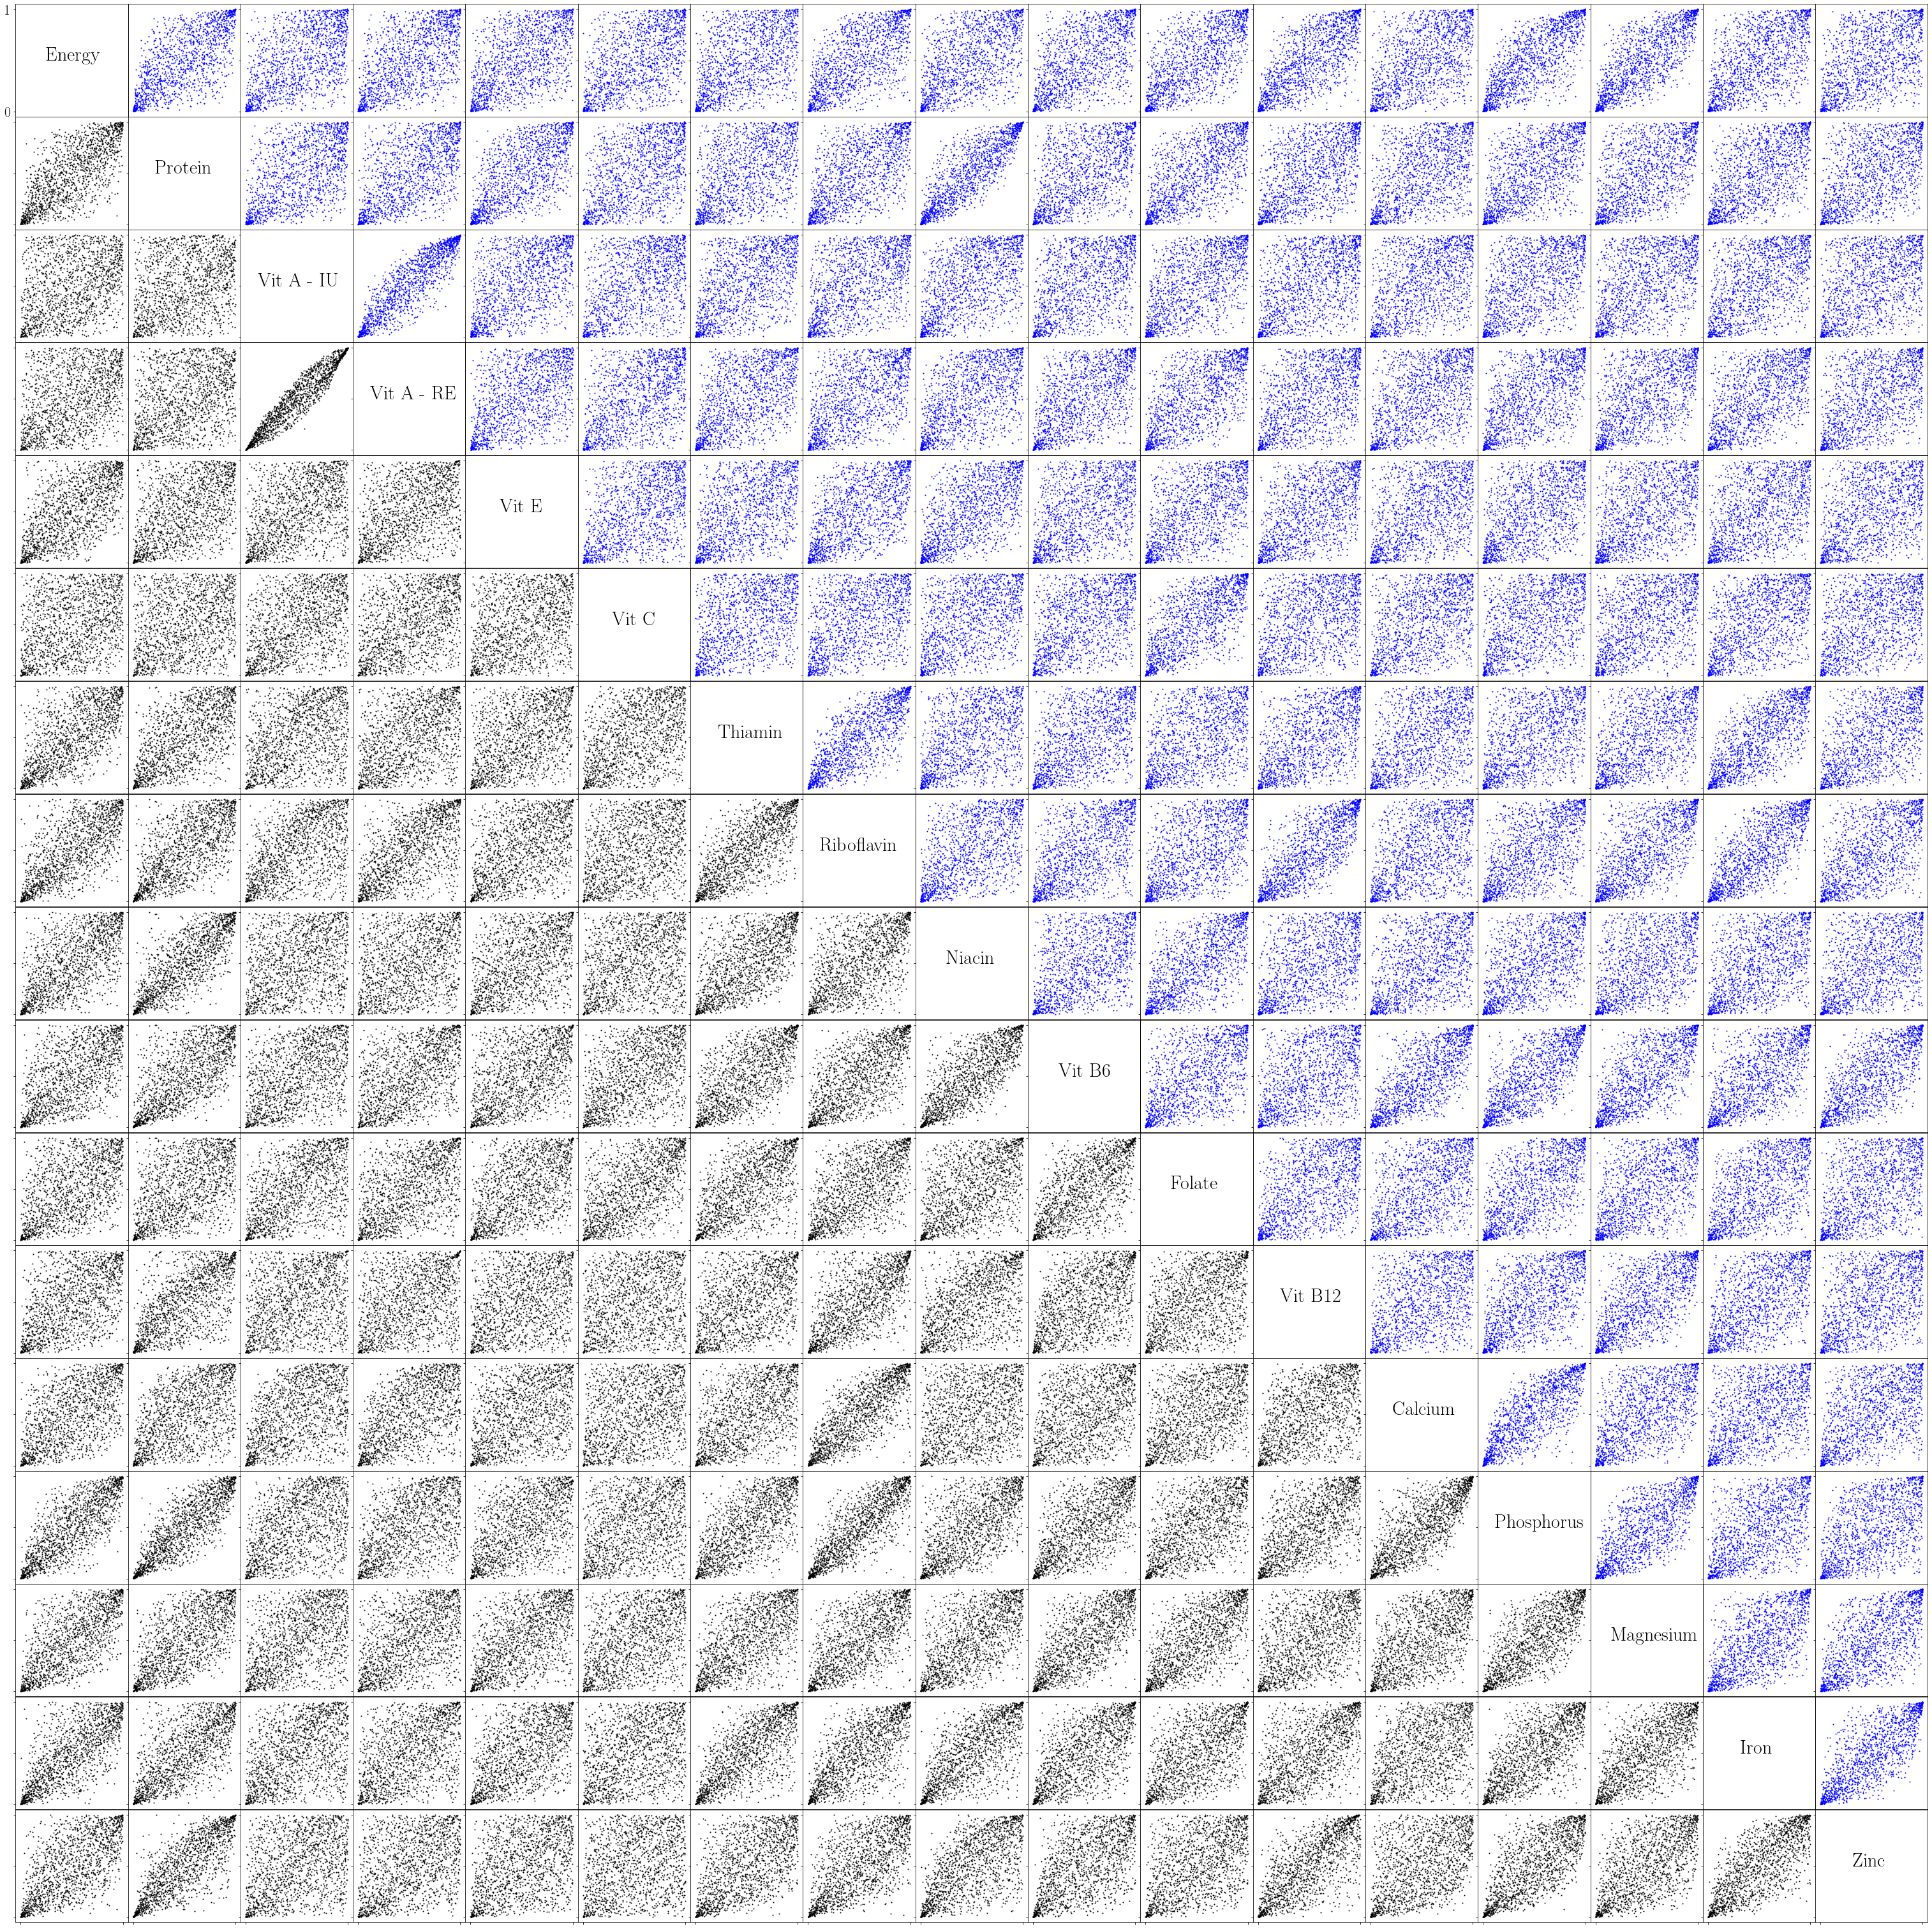

<Figure size 432x288 with 0 Axes>

In [6]:
U = phi(-torch.log(stdf_GNN.sample(nsamples))/phi.sample_M(nsamples).reshape(-1,1))
utils.plot_U1_U2(U,U0,labels=labels) #U1 in blue, U2 in black
